# Credit Risk Modelling 

In this project, we are using customer data collected from two sources. The first source is the bank's internal database, and the second is an external dataset that includes comprehensive information about customers from all financial institutions. This external dataset is obtained from the **CIBIL** database.


In [59]:
# importing important libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import warnings
import os


In [60]:
df1 = pd.read_excel("case_study1.xlsx")  #intrnal information
df2 = pd.read_excel("case_study2.xlsx")  #extrnal information

# Data Preprocessing
### Null Value Treatment

In [61]:
# Remove nulls
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]


In [62]:
# as data is big enogh around 51000 raws we can remove many of the null value raws but some columns have extream null values ie more than 1000 than we will remove that column 
columns_to_be_removed = []

for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)

In [63]:
print(columns_to_be_removed)

['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level', 'max_deliq_6mts', 'max_deliq_12mts', 'CC_utilization', 'PL_utilization', 'max_unsec_exposure_inPct']


In [64]:
df2 = df2.drop(columns_to_be_removed, axis =1)

In [65]:
for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]   # removing raws which has null values in that.

In [66]:
# Checking common column names
for i in list(df1.columns):
    if i in list(df2.columns):
        print (i)

PROSPECTID


In [67]:
# Merge the two dataframes, inner join so that no nulls are present
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42064 entries, 0 to 42063
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PROSPECTID                  42064 non-null  int64  
 1   Total_TL                    42064 non-null  int64  
 2   Tot_Closed_TL               42064 non-null  int64  
 3   Tot_Active_TL               42064 non-null  int64  
 4   Total_TL_opened_L6M         42064 non-null  int64  
 5   Tot_TL_closed_L6M           42064 non-null  int64  
 6   pct_tl_open_L6M             42064 non-null  float64
 7   pct_tl_closed_L6M           42064 non-null  float64
 8   pct_active_tl               42064 non-null  float64
 9   pct_closed_tl               42064 non-null  float64
 10  Total_TL_opened_L12M        42064 non-null  int64  
 11  Tot_TL_closed_L12M          42064 non-null  int64  
 12  pct_tl_open_L12M            42064 non-null  float64
 13  pct_tl_closed_L12M          420

### Data Visualization

In [69]:
# Calculate the sum of null values for each column
null_counts = df.isna().sum()

# Filter out columns with null values greater than zero
columns_with_null = null_counts[null_counts > 0]

# Print the features and their respective count of null values
print("Features with null values and their counts:")
print(columns_with_null)


Features with null values and their counts:
Series([], dtype: int64)


In [70]:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)


MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


In [71]:
# List of categorical features
categorical_features = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2', 'Approved_Flag']

# Print unique values for each categorical feature
for feature in categorical_features:
    unique_values = df[feature].unique()
    print(f"Unique values for {feature}: {unique_values}")


Unique values for MARITALSTATUS: ['Married' 'Single']
Unique values for EDUCATION: ['12TH' 'GRADUATE' 'SSC' 'POST-GRADUATE' 'UNDER GRADUATE' 'OTHERS'
 'PROFESSIONAL']
Unique values for GENDER: ['M' 'F']
Unique values for last_prod_enq2: ['PL' 'ConsumerLoan' 'AL' 'CC' 'others' 'HL']
Unique values for first_prod_enq2: ['PL' 'ConsumerLoan' 'others' 'AL' 'HL' 'CC']
Unique values for Approved_Flag: ['P2' 'P1' 'P3' 'P4']


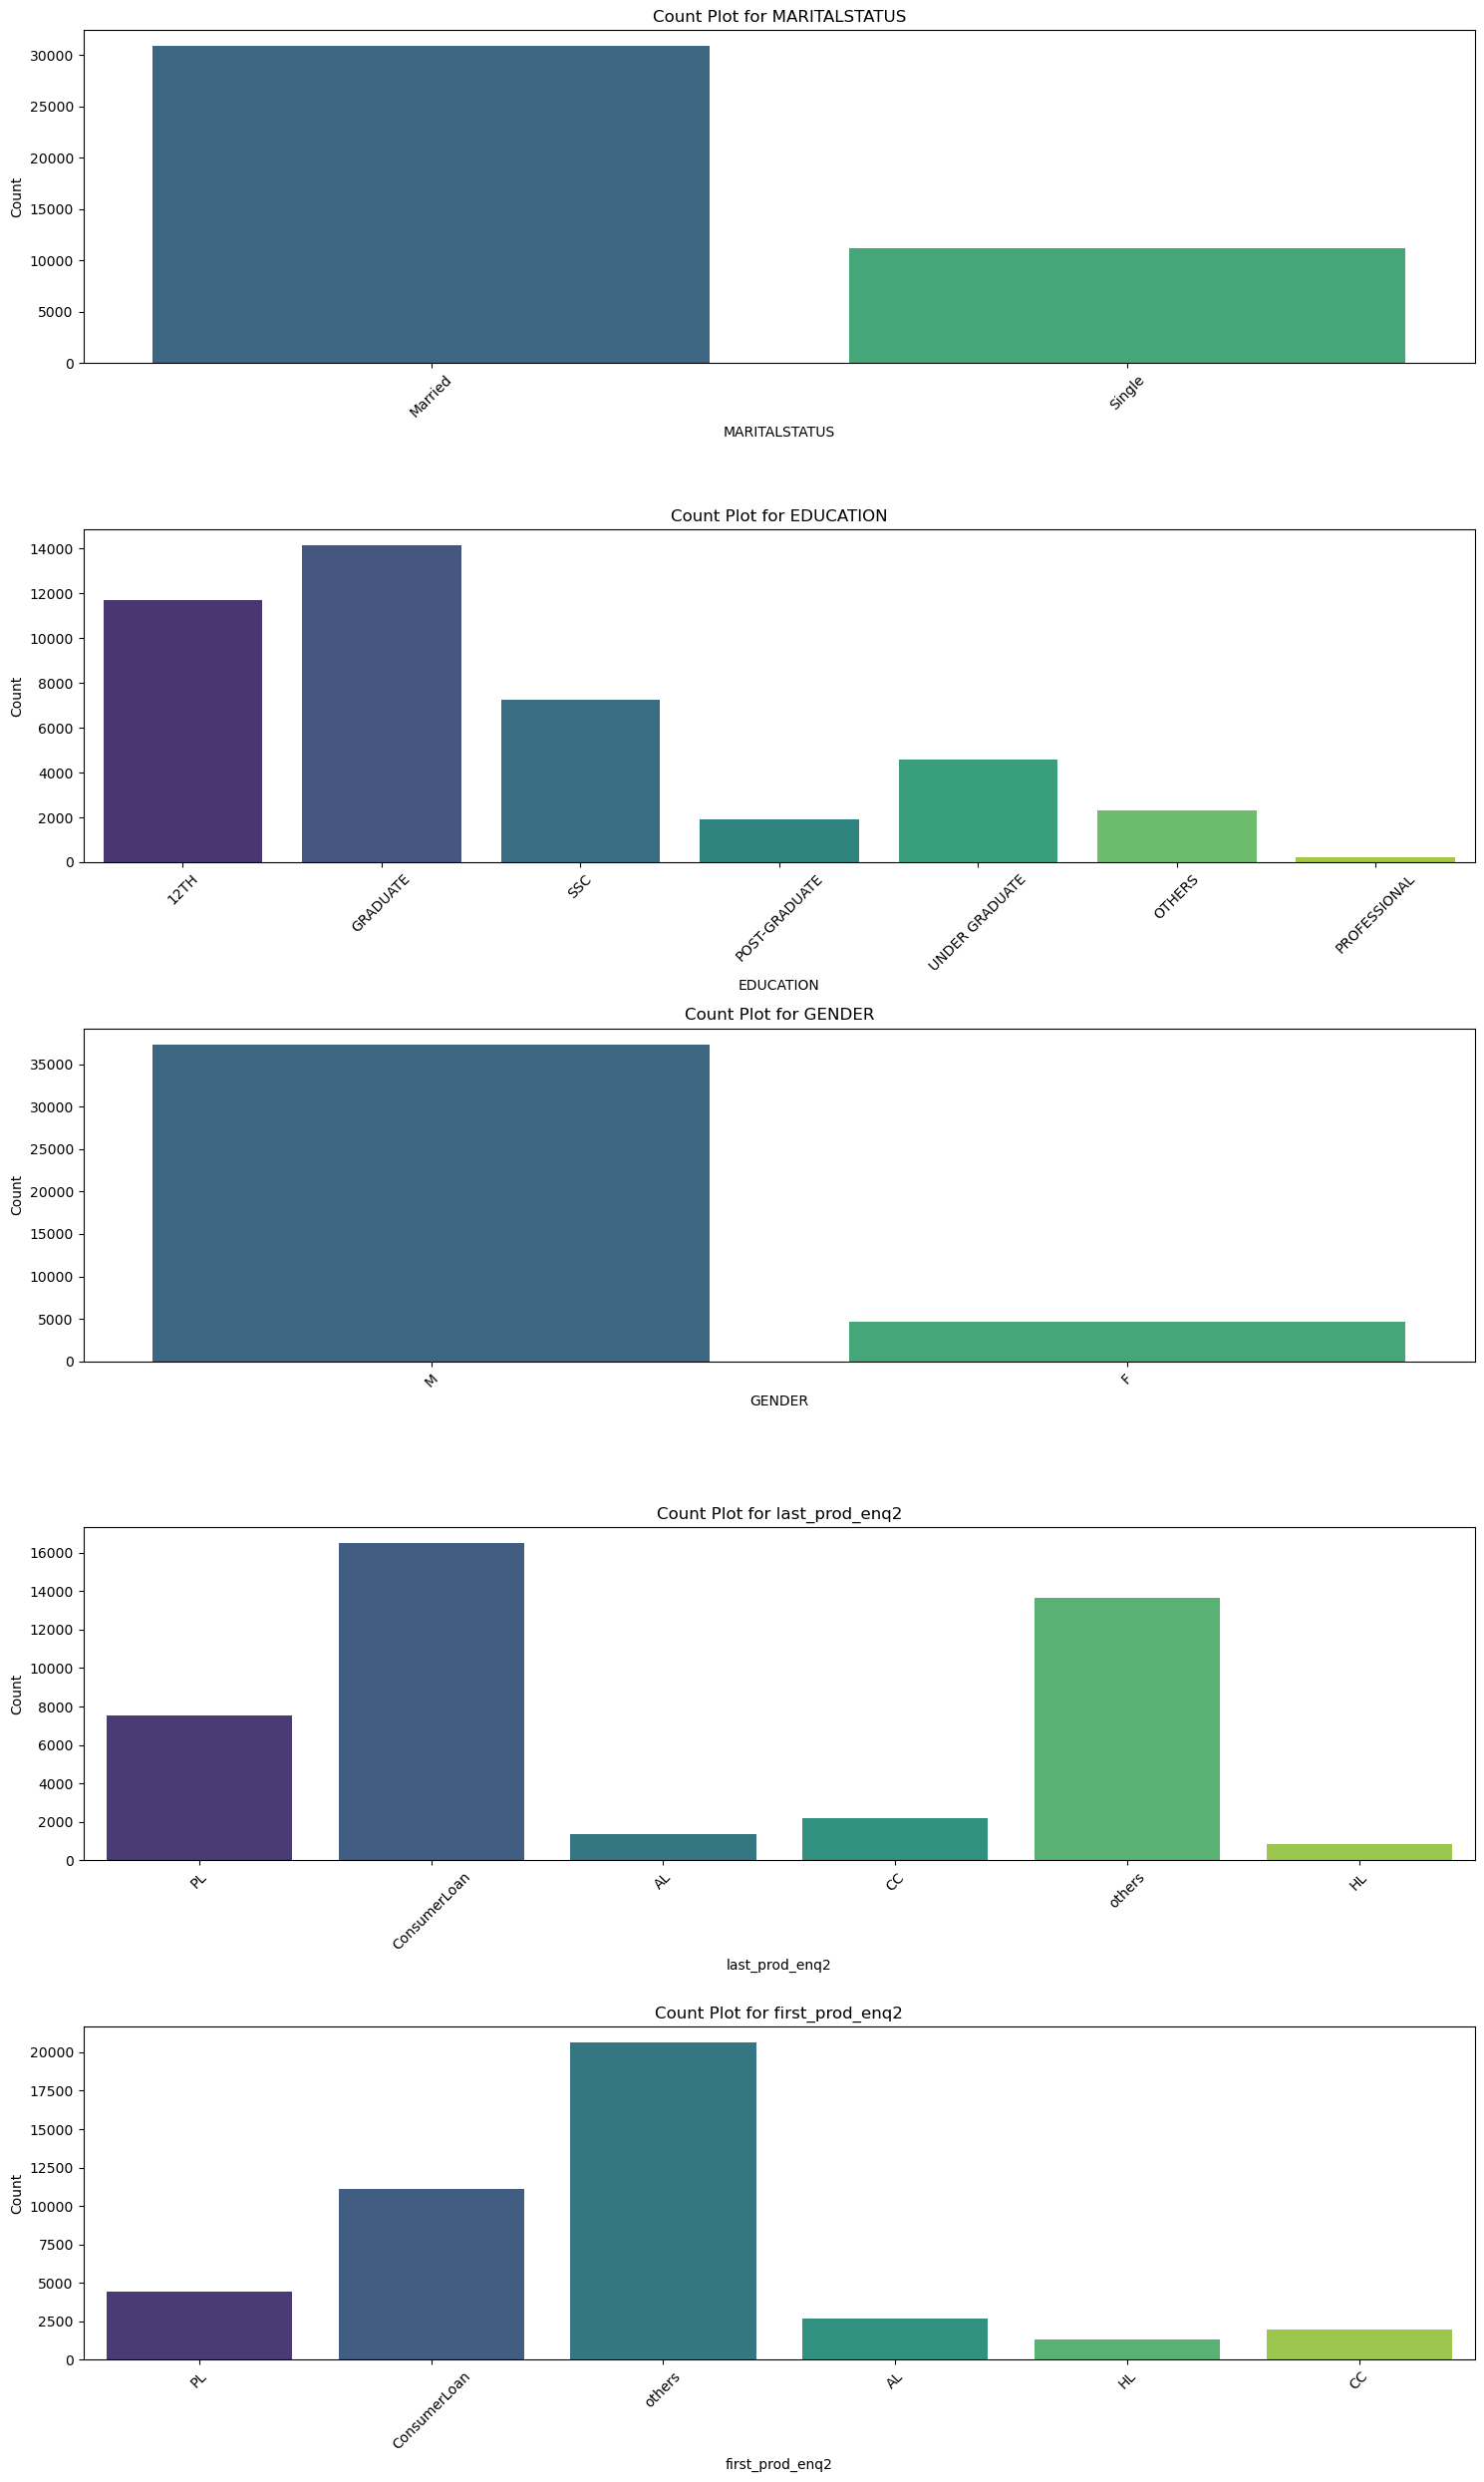

In [72]:
# List of categorical columns
categorical_columns = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

# Set up the plotting area
plt.figure(figsize=(15, 25))

# Loop through each categorical column and create a count plot
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Count Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

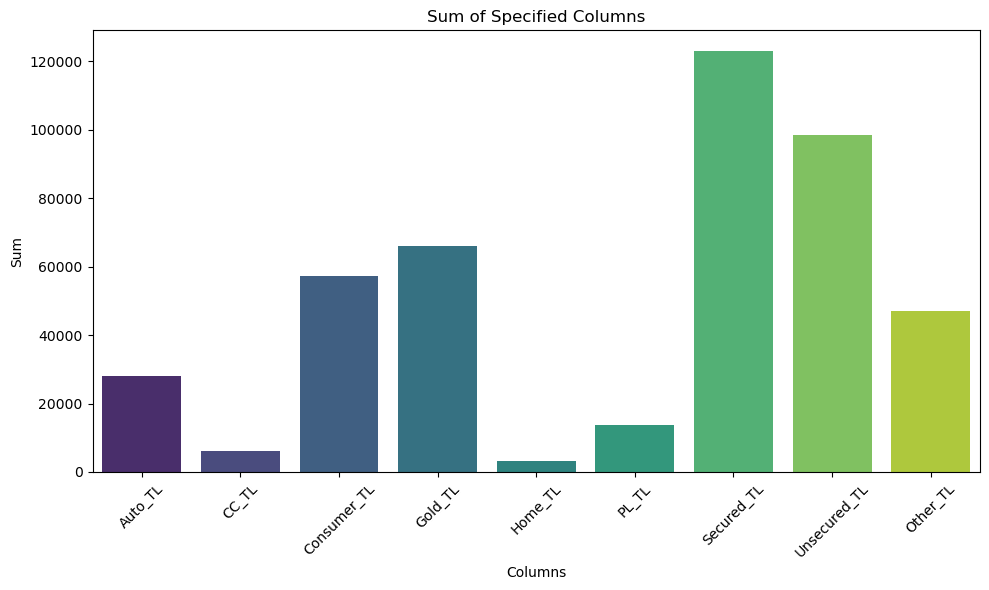

In [74]:
# List of columns to sum
columns_to_sum = ["Auto_TL", "CC_TL", "Consumer_TL", "Gold_TL", "Home_TL", "PL_TL", "Secured_TL", "Unsecured_TL", "Other_TL"]

# Calculate the sum of each column
column_sums = df[columns_to_sum].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette='viridis')
plt.title('Sum of Specified Columns')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

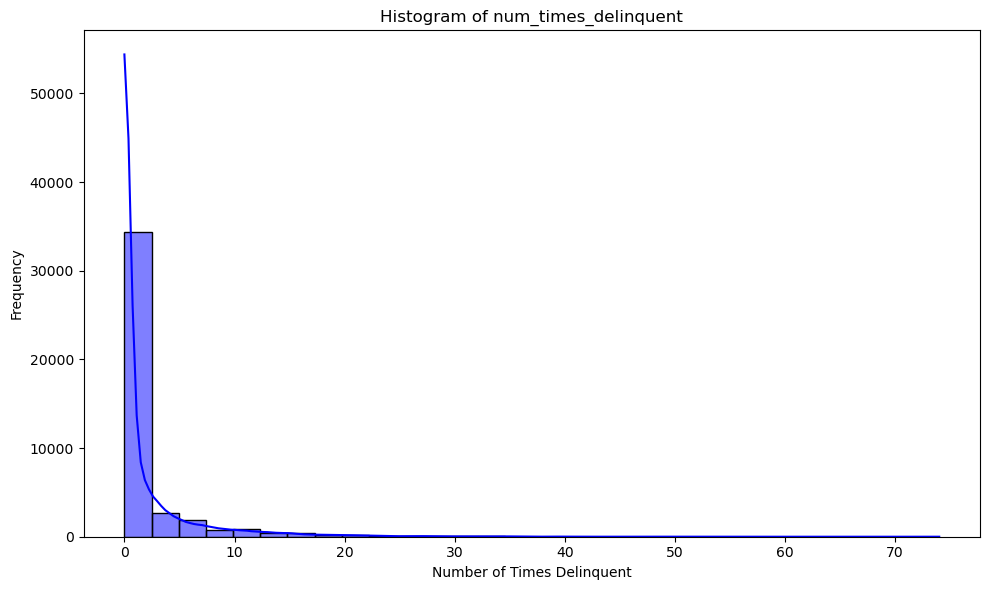

In [75]:
plt.figure(figsize=(10, 6))

# Create a histogram for 'num_times_delinquent'
sns.histplot(df['num_times_delinquent'], bins=30, kde=True, color='blue')
plt.title('Histogram of num_times_delinquent')
plt.xlabel('Number of Times Delinquent')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

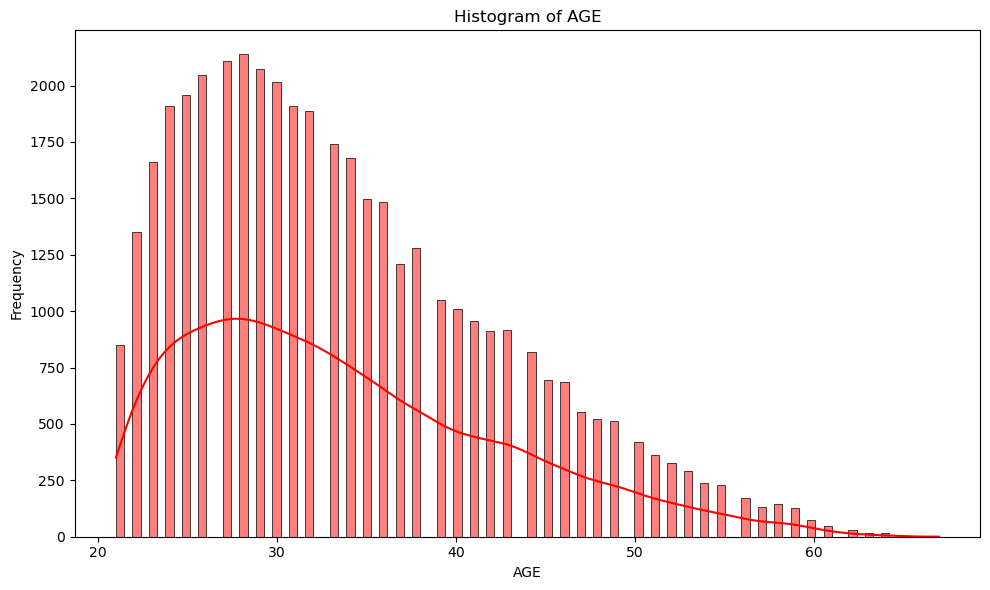

In [84]:
plt.figure(figsize=(10, 6))

# Create a histogram for 'num_times_delinquent'
sns.histplot(df['AGE'], bins=100, kde=True, color='red')
plt.title('Histogram of AGE')
plt.xlabel('AGE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

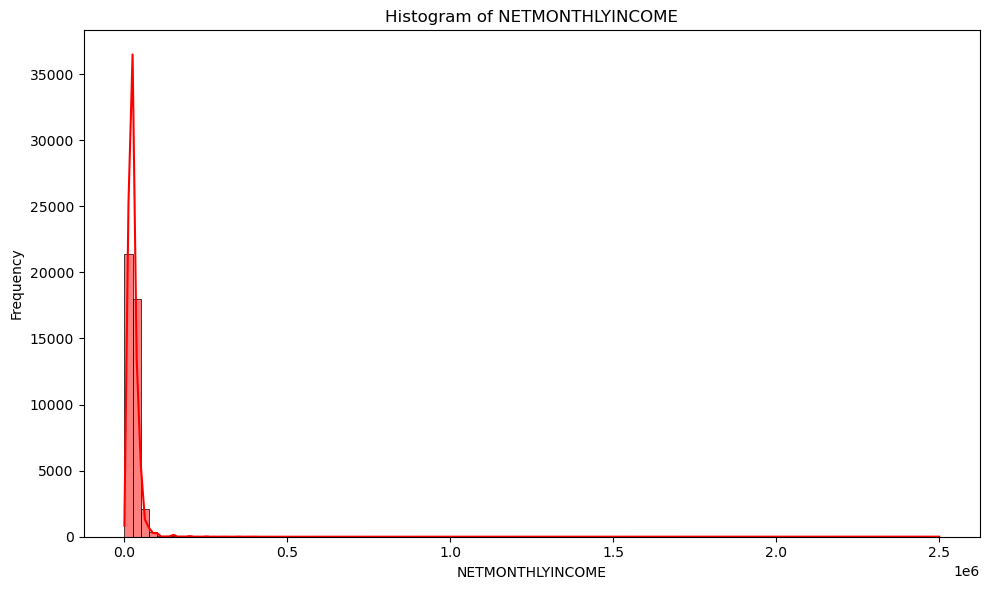

In [82]:
plt.figure(figsize=(10, 6))

# Create a histogram for 'num_times_delinquent'
sns.histplot(df["NETMONTHLYINCOME"], bins=100, kde=True, color='red')
plt.title('Histogram of NETMONTHLYINCOME')
plt.xlabel('NETMONTHLYINCOME')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

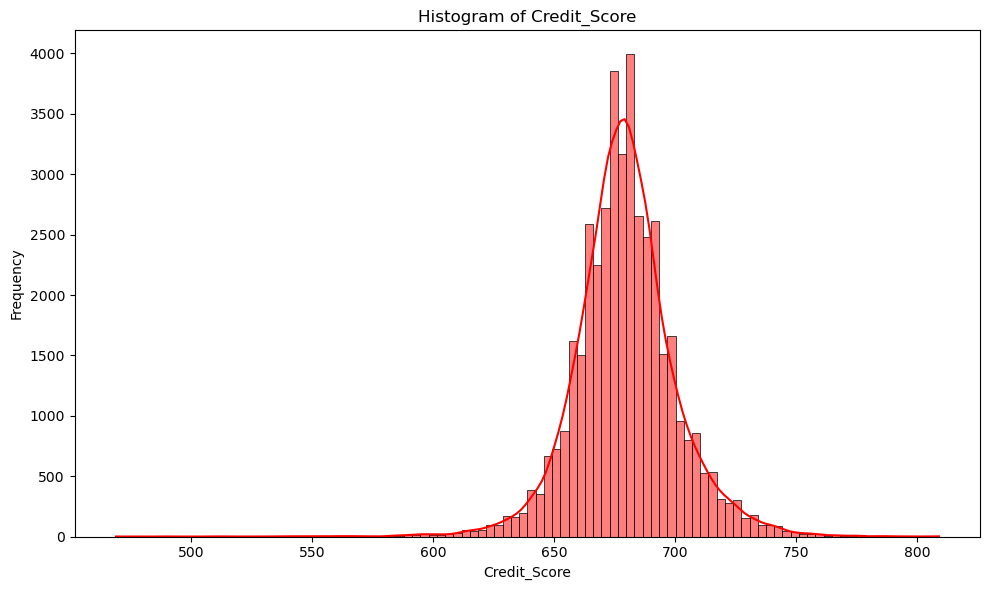

In [83]:
plt.figure(figsize=(10, 6))

# Create a histogram for 'num_times_delinquent'
sns.histplot(df["Credit_Score"], bins=100, kde=True, color='red')
plt.title('Histogram of Credit_Score')
plt.xlabel('Credit_Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

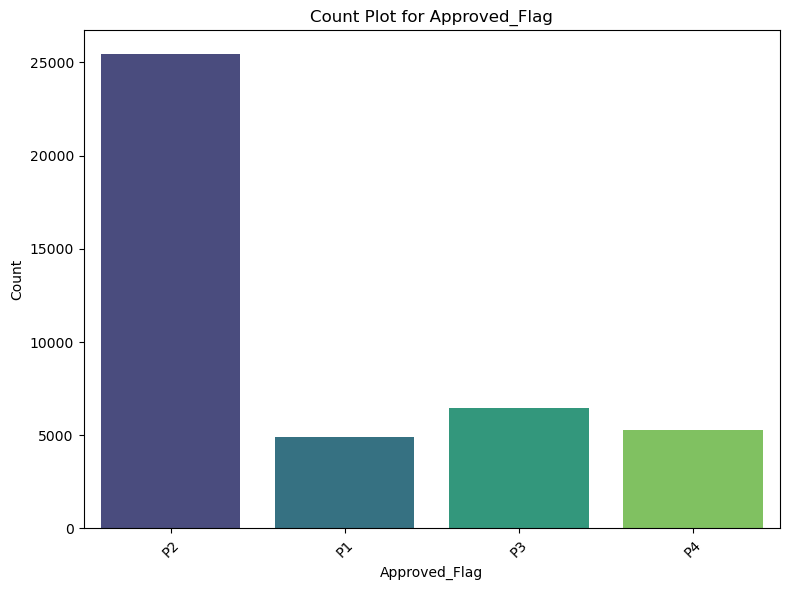

In [73]:
# Set up the plotting area
plt.figure(figsize=(8, 6))

# Create a count plot for 'Approved_Flag'
sns.countplot(data=df, x='Approved_Flag', palette='viridis')
plt.title('Count Plot for Approved_Flag')
plt.xlabel('Approved_Flag')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Chi-square test
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)


MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


all the categorical features are accociated with target variable "Approved_Flag" now cheakin multicolinearity of numerical features 

In [15]:
# VIF for numerical columns
numeric_columns = []
for i in df.columns:
    if df[i].dtype != 'object' and i not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(i)


In [16]:
# VIF sequentially check

vif_data = df[numeric_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0


In [17]:
for i in range (0,total_columns):
    
    vif_value = variance_inflation_factor(vif_data, column_index)
    print (column_index,'---',vif_value)
    
    
    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1
    
    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)



C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
0 --- 11.320180023967996
0 --- 8.363698035000327
0 --- 6.520647877790928
0 --- 5.149501618212625
1 --- 2.611111040579735


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477228
2 --- 3.8328007921530785
3 --- 6.0996533816467355
3 --- 5.581352009642762
4 --- 1.9855843530987785


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


5 --- inf
5 --- 4.80953830281934
6 --- 23.270628983464636
6 --- 30.595522588100053
6 --- 4.3843464059655854
7 --- 3.064658415523423
8 --- 2.898639771299252
9 --- 4.377876915347322
10 --- 2.2078535836958433
11 --- 4.916914200506864
12 --- 5.214702030064725
13 --- 3.3861625024231476
14 --- 7.840583309478997
14 --- 5.255034641721438


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


15 --- inf
15 --- 7.380634506427232
15 --- 1.421005001517573
16 --- 8.083255010190323
16 --- 1.6241227524040112
17 --- 7.257811920140003
17 --- 15.59624383268298
17 --- 1.825857047132431
18 --- 1.5080839450032664
19 --- 2.172088834824577
20 --- 2.623397553527229
21 --- 2.2959970812106167
22 --- 7.360578319196446
22 --- 2.1602387773102563
23 --- 2.8686288267891467
24 --- 6.458218003637272
24 --- 2.8474118865638256
25 --- 4.7531981562840855
26 --- 16.227354755948223
26 --- 6.424377256363877
26 --- 8.887080381808687
26 --- 2.3804746142952653
27 --- 8.60951347651454
27 --- 13.06755093547673
27 --- 3.500040056654654
28 --- 1.9087955874813773
29 --- 17.006562234161628
29 --- 10.730485153719197
29 --- 2.3538497522950275
30 --- 22.104855915136433
30 --- 2.7971639638512915
31 --- 3.424171203217696
32 --- 10.175021454450935
32 --- 6.408710354561301
32 --- 1.0011511962625608
33 --- 3.069197305397274
34 --- 2.8091261600643724
35 --- 20.249538381980678
35 --- 15.864576541593774
35 --- 1.83316497405

In [18]:
# check Anova for columns_to_be_kept 

from scipy.stats import f_oneway

columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)



In [19]:
# feature selection is done for cat and num features

# listing all the final features
features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]


In [20]:
df.shape

(42064, 43)

In [21]:
# Label encoding for the categorical features
['MARITALSTATUS', 'EDUCATION', 'GENDER' , 'last_prod_enq2' ,'first_prod_enq2']


['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

In [22]:
# List of categorical features
categorical_features = ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

# Print unique values for each categorical feature
for feature in categorical_features:
    unique_values = df[feature].unique()
    print(f"Unique values for {feature}: {unique_values}")


Unique values for MARITALSTATUS: ['Married' 'Single']
Unique values for EDUCATION: ['12TH' 'GRADUATE' 'SSC' 'POST-GRADUATE' 'UNDER GRADUATE' 'OTHERS'
 'PROFESSIONAL']
Unique values for GENDER: ['M' 'F']
Unique values for last_prod_enq2: ['PL' 'ConsumerLoan' 'AL' 'CC' 'others' 'HL']
Unique values for first_prod_enq2: ['PL' 'ConsumerLoan' 'others' 'AL' 'HL' 'CC']


# Ordinal feature -- EDUCATION
SSC            : 1  
12TH           : 2  
GRADUATE       : 3  
UNDER GRADUATE : 3  
POST-GRADUATE  : 4  
OTHERS         : 1  
PROFESSIONAL   : 3  
all other feature are nominal hance using one hot encoding in all other features

In [23]:
df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3


In [24]:
df['EDUCATION'].value_counts()
df['EDUCATION'] = df['EDUCATION'].astype(int)

In [25]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])


In [26]:
df_encoded.info()
k = df_encoded.describe()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42064 entries, 0 to 42063
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_tl_open_L6M               42064 non-null  float64
 1   pct_tl_closed_L6M             42064 non-null  float64
 2   Tot_TL_closed_L12M            42064 non-null  int64  
 3   pct_tl_closed_L12M            42064 non-null  float64
 4   Tot_Missed_Pmnt               42064 non-null  int64  
 5   CC_TL                         42064 non-null  int64  
 6   Home_TL                       42064 non-null  int64  
 7   PL_TL                         42064 non-null  int64  
 8   Secured_TL                    42064 non-null  int64  
 9   Unsecured_TL                  42064 non-null  int64  
 10  Other_TL                      42064 non-null  int64  
 11  Age_Oldest_TL                 42064 non-null  int64  
 12  Age_Newest_TL                 42064 non-null  int64  
 13  t

In [27]:
# Install XGBoost if not already installed
!pip install xgboost

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings

warnings.filterwarnings('ignore')


In [28]:
# Assuming df_encoded is your preprocessed DataFrame
X = df_encoded.drop('Approved_Flag', axis=1)
y = df_encoded['Approved_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM": SVC(probability=True)
}


In [29]:
def evaluate_model(name, model):
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        
        print(f"\n{name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"Error evaluating {name}: {e}")


### Decision tree model:

In [30]:
evaluate_model("Decision Tree", DecisionTreeClassifier())


Decision Tree
Accuracy: 0.7034
Precision: [0.73312883 0.81262445 0.33431953 0.62959472]
Recall: [0.70710059 0.80891972 0.34113208 0.64917396]
F1 Score: [0.71987952 0.81076786 0.33769145 0.63923445]

Classification Report:
              precision    recall  f1-score   support

          P1       0.73      0.71      0.72      1014
          P2       0.81      0.81      0.81      5045
          P3       0.33      0.34      0.34      1325
          P4       0.63      0.65      0.64      1029

    accuracy                           0.70      8413
   macro avg       0.63      0.63      0.63      8413
weighted avg       0.71      0.70      0.70      8413



### Random forest

In [31]:
evaluate_model("Random Forest", RandomForestClassifier())


Random Forest
Accuracy: 0.7641
Precision: [0.83256351 0.79696815 0.44189602 0.72309198]
Recall: [0.71104536 0.92745292 0.21811321 0.71817298]
F1 Score: [0.76702128 0.85727373 0.2920667  0.72062409]

Classification Report:
              precision    recall  f1-score   support

          P1       0.83      0.71      0.77      1014
          P2       0.80      0.93      0.86      5045
          P3       0.44      0.22      0.29      1325
          P4       0.72      0.72      0.72      1029

    accuracy                           0.76      8413
   macro avg       0.70      0.64      0.66      8413
weighted avg       0.74      0.76      0.74      8413



### Logistic Regression:

In [32]:
evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000))


Logistic Regression
Accuracy: 0.6308
Precision: [0.6147541  0.63558643 0.         0.54395604]
Recall: [0.44378698 0.94311199 0.         0.09620991]
F1 Score: [0.51546392 0.7593967  0.         0.16350124]

Classification Report:
              precision    recall  f1-score   support

          P1       0.61      0.44      0.52      1014
          P2       0.64      0.94      0.76      5045
          P3       0.00      0.00      0.00      1325
          P4       0.54      0.10      0.16      1029

    accuracy                           0.63      8413
   macro avg       0.45      0.37      0.36      8413
weighted avg       0.52      0.63      0.54      8413



### KNN

In [42]:
evaluate_model("KNN", KNeighborsClassifier(n_neighbors=10))

Error evaluating KNN: 'NoneType' object has no attribute 'split'


### Naive Bayes

In [34]:
 evaluate_model("Naive Bayes", GaussianNB())


Naive Bayes
Accuracy: 0.6532
Precision: [0.57388316 0.73528387 0.332397   0.57123288]
Recall: [0.49408284 0.83686819 0.26792453 0.40524781]
F1 Score: [0.53100159 0.7827941  0.2966987  0.47413303]

Classification Report:
              precision    recall  f1-score   support

          P1       0.57      0.49      0.53      1014
          P2       0.74      0.84      0.78      5045
          P3       0.33      0.27      0.30      1325
          P4       0.57      0.41      0.47      1029

    accuracy                           0.65      8413
   macro avg       0.55      0.50      0.52      8413
weighted avg       0.63      0.65      0.64      8413



### XGboost

In [36]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',  num_class=4)



y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)




xgb_classifier.fit(x_train, y_train)
y_pred = xgb_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print ()
print(f'Accuracy: {accuracy:.2f}')
print ()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()



Accuracy: 0.78

Class p1:
Precision: 0.8272532188841202
Recall: 0.7603550295857988
F1 Score: 0.7923946557040081

Class p2:
Precision: 0.8246241947029349
Recall: 0.9133795837462835
F1 Score: 0.8667356343459044

Class p3:
Precision: 0.4555940023068051
Recall: 0.2981132075471698
F1 Score: 0.36040145985401456

Class p4:
Precision: 0.7290448343079922
Recall: 0.7269193391642371
F1 Score: 0.7279805352798053



from the above ovbservations we can observe that XGboost has highest Accuracy 78% hance i will select XGboost to further finetune it. 

### Fine tuning the XGboost Model

In [43]:
# some columns of the df need to scaled 
from sklearn.preprocessing import StandardScaler

columns_to_be_scaled = ['Age_Oldest_TL','Age_Newest_TL','time_since_recent_payment',
'max_recent_level_of_deliq','recent_level_of_deliq',
'time_since_recent_enq','NETMONTHLYINCOME','Time_With_Curr_Empr']

for i in columns_to_be_scaled:
    column_data = df_encoded[i].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_column = scaler.fit_transform(column_data)
    df_encoded[i] = scaled_column

In [44]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',  num_class=4)


y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [45]:
xgb_classifier.fit(x_train, y_train)
y_pred = xgb_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

for i, v in enumerate(['p1', 'p2', 'p3', 'p4']):
    print(f"Class {v}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1_score[i]}")
    print()


Accuracy: 0.78
Class p1:
Precision: 0.8272532188841202
Recall: 0.7603550295857988
F1 Score: 0.7923946557040081

Class p2:
Precision: 0.8244766505636071
Recall: 0.9133795837462835
F1 Score: 0.8666541282678203

Class p3:
Precision: 0.4555940023068051
Recall: 0.2981132075471698
F1 Score: 0.36040145985401456

Class p4:
Precision: 0.7297560975609756
Recall: 0.7269193391642371
F1 Score: 0.7283349561830574



#### Hyperparameter Tuning

In [46]:
# Hyperparameter tuning in xgboost
from sklearn.model_selection import GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

# Define the XGBClassifier with the initial set of hyperparameters
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

# Define the parameter grid for hyperparameter tuning

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(x_test, y_test)
print("Test Accuracy:", accuracy)

# Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


# Based on risk appetite of the bank, you will suggest P1,P2,P3,P4 to the business end user







Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Test Accuracy: 0.779983359087127


In [48]:
# Define the hyperparameter grid
param_grid = {

    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],
    'learning_rate'   : [0.001, 0.01, 0.1, 1],
    'max_depth'       : [3, 5, 8, 10],
    'alpha'           : [1, 10, 100],
    'n_estimators'    : [10,50,100]
 } 


In [ ]:
index = 0

answers_grid = {
    'combination'       :[],
    'train_Accuracy'    :[],
    'test_Accuracy'     :[],
    'colsample_bytree'  :[],
    'learning_rate'     :[],
    'max_depth'         :[],
    'alpha'             :[],
    'n_estimators'      :[]
    }



In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# Assuming df_encoded is your preprocessed DataFrame
y = df_encoded['Approved_Flag']
X = df_encoded.drop('Approved_Flag', axis=1)

# Check for missing values
print("Missing values in each column:\n", X.isnull().sum())

# Fill missing values (if any) with the mean of the column
X.fillna(X.mean(), inplace=True)

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features (optional, but often helps with model performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define hyperparameters grid
param_grid = {
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'alpha': [0, 0.1, 1],
    'n_estimators': [50, 100, 200]
}

index = 0

# Initialize list to store results
results = []

# Loop through each combination of hyperparameters
for colsample_bytree in param_grid['colsample_bytree']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for alpha in param_grid['alpha']:
                for n_estimators in param_grid['n_estimators']:
                    
                    index += 1
                    
                    # Define and train the XGBoost model
                    model = xgb.XGBClassifier(objective='multi:softmax',
                                              num_class=4,
                                              colsample_bytree=colsample_bytree,
                                              learning_rate=learning_rate,
                                              max_depth=max_depth,
                                              alpha=alpha,
                                              n_estimators=n_estimators)
                    
                    # Train the model
                    model.fit(X_train, y_train)
                    
                    # Predict on the test set
                    y_pred = model.predict(X_test)
                    
                    # Evaluate the model
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred, average=None)
                    recall = recall_score(y_test, y_pred, average=None)
                    f1 = f1_score(y_test, y_pred, average=None)
                    
                    # Store the results
                    results.append({
                        'index': index,
                        'colsample_bytree': colsample_bytree,
                        'learning_rate': learning_rate,
                        'max_depth': max_depth,
                        'alpha': alpha,
                        'n_estimators': n_estimators,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'classification_report': classification_report(y_test, y_pred, target_names=label_encoder.classes_)
                    })
                    
                    print(f"Index: {index}")
                    print(f"Hyperparameters: colsample_bytree={colsample_bytree}, learning_rate={learning_rate}, max_depth={max_depth}, alpha={alpha}, n_estimators={n_estimators}")
                    print(f"Accuracy: {accuracy:.4f}")
                    print(f"Precision: {precision}")
                    print(f"Recall: {recall}")
                    print(f"F1 Score: {f1}")
                    print("\nClassification Report:")
                    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
                    print("\n" + "="*60 + "\n")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


Missing values in each column:
 pct_tl_open_L6M                 0
pct_tl_closed_L6M               0
Tot_TL_closed_L12M              0
pct_tl_closed_L12M              0
Tot_Missed_Pmnt                 0
CC_TL                           0
Home_TL                         0
PL_TL                           0
Secured_TL                      0
Unsecured_TL                    0
Other_TL                        0
Age_Oldest_TL                   0
Age_Newest_TL                   0
time_since_recent_payment       0
max_recent_level_of_deliq       0
num_deliq_6_12mts               0
num_times_60p_dpd               0
num_std_12mts                   0
num_sub                         0
num_sub_6mts                    0
num_sub_12mts                   0
num_dbt                         0
num_dbt_12mts                   0
num_lss                         0
recent_level_of_deliq           0
CC_enq_L12m                     0
PL_enq_L12m                     0
time_since_recent_enq           0
enq_L3m         

Index: 9
Hyperparameters: colsample_bytree=0.3, learning_rate=0.01, max_depth=3, alpha=1, n_estimators=200
Accuracy: 0.6932
Precision: [0.94078947 0.67361204 0.         0.79970105]
Recall: [0.28205128 0.99326065 0.         0.51992225]
F1 Score: [0.4339909  0.80278757 0.         0.63015312]

Classification Report:
              precision    recall  f1-score   support

          P1       0.94      0.28      0.43      1014
          P2       0.67      0.99      0.80      5045
          P3       0.00      0.00      0.00      1325
          P4       0.80      0.52      0.63      1029

    accuracy                           0.69      8413
   macro avg       0.60      0.45      0.47      8413
weighted avg       0.62      0.69      0.61      8413



Index: 10
Hyperparameters: colsample_bytree=0.3, learning_rate=0.01, max_depth=5, alpha=0, n_estimators=50
Accuracy: 0.6814
Precision: [0.94979079 0.66239768 0.         0.8163606 ]
Recall: [0.22386588 0.99444995 0.         0.47521866]
F1 Score: [0.

Index: 20
Hyperparameters: colsample_bytree=0.3, learning_rate=0.01, max_depth=7, alpha=0, n_estimators=100
Accuracy: 0.6993
Precision: [0.92897727 0.67995646 0.55172414 0.79502196]
Recall: [0.32248521 0.99048563 0.01207547 0.52769679]
F1 Score: [0.47877013 0.80635792 0.02363368 0.63434579]

Classification Report:
              precision    recall  f1-score   support

          P1       0.93      0.32      0.48      1014
          P2       0.68      0.99      0.81      5045
          P3       0.55      0.01      0.02      1325
          P4       0.80      0.53      0.63      1029

    accuracy                           0.70      8413
   macro avg       0.74      0.46      0.49      8413
weighted avg       0.70      0.70      0.62      8413



Index: 21
Hyperparameters: colsample_bytree=0.3, learning_rate=0.01, max_depth=7, alpha=0, n_estimators=200
Accuracy: 0.7257
Precision: [0.91750503 0.71107613 0.50819672 0.76674938]
Recall: [0.44970414 0.98493558 0.04679245 0.60058309]
F1 Score: [

Index: 31
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=3, alpha=0.1, n_estimators=50
Accuracy: 0.7332
Precision: [0.89350181 0.72403169 0.46774194 0.73993471]
Recall: [0.48816568 0.97819623 0.04377358 0.66083576]
F1 Score: [0.63137755 0.83213894 0.08005521 0.69815195]

Classification Report:
              precision    recall  f1-score   support

          P1       0.89      0.49      0.63      1014
          P2       0.72      0.98      0.83      5045
          P3       0.47      0.04      0.08      1325
          P4       0.74      0.66      0.70      1029

    accuracy                           0.73      8413
   macro avg       0.71      0.54      0.56      8413
weighted avg       0.71      0.73      0.67      8413



Index: 32
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=3, alpha=0.1, n_estimators=100
Accuracy: 0.7613
Precision: [0.87346939 0.77009851 0.48333333 0.73962656]
Recall: [0.63313609 0.96075322 0.15320755 0.69290573]
F1 Score: 

Index: 42
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=0.1, n_estimators=200
Accuracy: 0.7753
Precision: [0.84521158 0.81294465 0.44652406 0.74203187]
Recall: [0.74852071 0.92864222 0.25207547 0.72400389]
F1 Score: [0.79393305 0.86695041 0.3222383  0.73290703]

Classification Report:
              precision    recall  f1-score   support

          P1       0.85      0.75      0.79      1014
          P2       0.81      0.93      0.87      5045
          P3       0.45      0.25      0.32      1325
          P4       0.74      0.72      0.73      1029

    accuracy                           0.78      8413
   macro avg       0.71      0.66      0.68      8413
weighted avg       0.75      0.78      0.76      8413



Index: 43
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=1, n_estimators=50
Accuracy: 0.7492
Precision: [0.87748851 0.7526267  0.45797101 0.74337222]
Recall: [0.56508876 0.96551041 0.11924528 0.68124393]
F1 Score: [0

Index: 53
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=7, alpha=1, n_estimators=100
Accuracy: 0.7685
Precision: [0.85714286 0.79556898 0.44977511 0.74613003]
Recall: [0.69230769 0.9395441  0.22641509 0.70262391]
F1 Score: [0.76595745 0.8615832  0.30120482 0.72372372]

Classification Report:
              precision    recall  f1-score   support

          P1       0.86      0.69      0.77      1014
          P2       0.80      0.94      0.86      5045
          P3       0.45      0.23      0.30      1325
          P4       0.75      0.70      0.72      1029

    accuracy                           0.77      8413
   macro avg       0.71      0.64      0.66      8413
weighted avg       0.74      0.77      0.74      8413



Index: 54
Hyperparameters: colsample_bytree=0.3, learning_rate=0.1, max_depth=7, alpha=1, n_estimators=200
Accuracy: 0.7769
Precision: [0.84675615 0.81488583 0.461837   0.74033697]
Recall: [0.74654832 0.92666006 0.26943396 0.72594752]
F1 Score: [0.

Index: 64
Hyperparameters: colsample_bytree=0.3, learning_rate=0.3, max_depth=5, alpha=0, n_estimators=50
Accuracy: 0.7712
Precision: [0.84018265 0.80566524 0.4471086  0.73978066]
Recall: [0.72583826 0.93022795 0.23924528 0.72108844]
F1 Score: [0.77883598 0.86347746 0.31170108 0.73031496]

Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.73      0.78      1014
          P2       0.81      0.93      0.86      5045
          P3       0.45      0.24      0.31      1325
          P4       0.74      0.72      0.73      1029

    accuracy                           0.77      8413
   macro avg       0.71      0.65      0.67      8413
weighted avg       0.75      0.77      0.75      8413



Index: 65
Hyperparameters: colsample_bytree=0.3, learning_rate=0.3, max_depth=5, alpha=0, n_estimators=100
Accuracy: 0.7761
Precision: [0.84216336 0.81802213 0.4523507  0.73320351]
Recall: [0.75246548 0.92309217 0.26867925 0.73177843]
F1 Score: [0.7

Index: 75
Hyperparameters: colsample_bytree=0.3, learning_rate=0.3, max_depth=7, alpha=0, n_estimators=200
Accuracy: 0.7706
Precision: [0.82410423 0.81763456 0.44743276 0.72124756]
Recall: [0.74852071 0.91536174 0.27622642 0.7191448 ]
F1 Score: [0.78449612 0.86374264 0.34157723 0.72019465]

Classification Report:
              precision    recall  f1-score   support

          P1       0.82      0.75      0.78      1014
          P2       0.82      0.92      0.86      5045
          P3       0.45      0.28      0.34      1325
          P4       0.72      0.72      0.72      1029

    accuracy                           0.77      8413
   macro avg       0.70      0.66      0.68      8413
weighted avg       0.75      0.77      0.75      8413



Index: 76
Hyperparameters: colsample_bytree=0.3, learning_rate=0.3, max_depth=7, alpha=0.1, n_estimators=50
Accuracy: 0.7700
Precision: [0.83863636 0.80542127 0.44911805 0.74103586]
Recall: [0.72781065 0.9246779  0.24981132 0.72303207]
F1 Score: [0

Index: 86
Hyperparameters: colsample_bytree=0.5, learning_rate=0.01, max_depth=3, alpha=0.1, n_estimators=100
Accuracy: 0.7123
Precision: [0.89885057 0.69497908 0.         0.76608911]
Recall: [0.38560158 0.9877106  0.         0.60155491]
F1 Score: [0.53968254 0.81588211 0.         0.67392488]

Classification Report:
              precision    recall  f1-score   support

          P1       0.90      0.39      0.54      1014
          P2       0.69      0.99      0.82      5045
          P3       0.00      0.00      0.00      1325
          P4       0.77      0.60      0.67      1029

    accuracy                           0.71      8413
   macro avg       0.59      0.49      0.51      8413
weighted avg       0.62      0.71      0.64      8413



Index: 87
Hyperparameters: colsample_bytree=0.5, learning_rate=0.01, max_depth=3, alpha=0.1, n_estimators=200
Accuracy: 0.7272
Precision: [0.900369   0.71235826 0.5        0.74211712]
Recall: [0.48126233 0.98374628 0.00603774 0.6404276 ]
F1 Scor

Index: 97
Hyperparameters: colsample_bytree=0.5, learning_rate=0.01, max_depth=5, alpha=1, n_estimators=50
Accuracy: 0.7329
Precision: [0.92190476 0.71777104 0.625      0.74074074]
Recall: [0.47731755 0.98553023 0.00754717 0.68027211]
F1 Score: [0.62897986 0.83060474 0.01491424 0.70921986]

Classification Report:
              precision    recall  f1-score   support

          P1       0.92      0.48      0.63      1014
          P2       0.72      0.99      0.83      5045
          P3       0.62      0.01      0.01      1325
          P4       0.74      0.68      0.71      1029

    accuracy                           0.73      8413
   macro avg       0.75      0.54      0.55      8413
weighted avg       0.73      0.73      0.66      8413



Index: 98
Hyperparameters: colsample_bytree=0.5, learning_rate=0.01, max_depth=5, alpha=1, n_estimators=100
Accuracy: 0.7405
Precision: [0.91326531 0.72944297 0.48192771 0.73535565]
Recall: [0.5295858  0.98116947 0.03018868 0.68318756]
F1 Score: [0

Index: 108
Hyperparameters: colsample_bytree=0.5, learning_rate=0.01, max_depth=7, alpha=1, n_estimators=200
Accuracy: 0.7620
Precision: [0.8829932  0.7698778  0.46596859 0.73668342]
Recall: [0.64003945 0.96154609 0.13433962 0.71234208]
F1 Score: [0.74213836 0.85510312 0.20855302 0.7243083 ]

Classification Report:
              precision    recall  f1-score   support

          P1       0.88      0.64      0.74      1014
          P2       0.77      0.96      0.86      5045
          P3       0.47      0.13      0.21      1325
          P4       0.74      0.71      0.72      1029

    accuracy                           0.76      8413
   macro avg       0.71      0.61      0.63      8413
weighted avg       0.73      0.76      0.72      8413



Index: 109
Hyperparameters: colsample_bytree=0.5, learning_rate=0.1, max_depth=3, alpha=0, n_estimators=50
Accuracy: 0.7512
Precision: [0.88555079 0.75076453 0.42654028 0.72793354]
Recall: [0.61045365 0.97324083 0.06792453 0.68124393]
F1 Score: [

Index: 119
Hyperparameters: colsample_bytree=0.5, learning_rate=0.1, max_depth=5, alpha=0, n_estimators=100
Accuracy: 0.7763
Precision: [0.84797297 0.80845216 0.47569956 0.73073171]
Recall: [0.74260355 0.93280476 0.24377358 0.72789116]
F1 Score: [0.79179811 0.86618811 0.32235529 0.72930867]

Classification Report:
              precision    recall  f1-score   support

          P1       0.85      0.74      0.79      1014
          P2       0.81      0.93      0.87      5045
          P3       0.48      0.24      0.32      1325
          P4       0.73      0.73      0.73      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.66      0.68      8413
weighted avg       0.75      0.78      0.75      8413



Index: 120
Hyperparameters: colsample_bytree=0.5, learning_rate=0.1, max_depth=5, alpha=0, n_estimators=200
Accuracy: 0.7787
Precision: [0.84395604 0.81835732 0.46322581 0.73883495]
Recall: [0.75739645 0.92428147 0.2709434  0.73955296]
F1 Score: [

Index: 130
Hyperparameters: colsample_bytree=0.5, learning_rate=0.1, max_depth=7, alpha=0.1, n_estimators=50
Accuracy: 0.7712
Precision: [0.85748503 0.79868819 0.45283019 0.73795181]
Recall: [0.7061144  0.94132805 0.21735849 0.71428571]
F1 Score: [0.77447269 0.86416159 0.29372769 0.72592593]

Classification Report:
              precision    recall  f1-score   support

          P1       0.86      0.71      0.77      1014
          P2       0.80      0.94      0.86      5045
          P3       0.45      0.22      0.29      1325
          P4       0.74      0.71      0.73      1029

    accuracy                           0.77      8413
   macro avg       0.71      0.64      0.66      8413
weighted avg       0.74      0.77      0.75      8413



Index: 131
Hyperparameters: colsample_bytree=0.5, learning_rate=0.1, max_depth=7, alpha=0.1, n_estimators=100
Accuracy: 0.7756
Precision: [0.83789704 0.81709881 0.45115681 0.734714  ]
Recall: [0.75443787 0.92447968 0.26490566 0.72400389]
F1 Score

Index: 141
Hyperparameters: colsample_bytree=0.5, learning_rate=0.3, max_depth=3, alpha=0.1, n_estimators=200
Accuracy: 0.7807
Precision: [0.84490239 0.82163588 0.45618557 0.74174757]
Recall: [0.76824458 0.9258672  0.26716981 0.74246842]
F1 Score: [0.80475207 0.87064306 0.33698239 0.74210782]

Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.77      0.80      1014
          P2       0.82      0.93      0.87      5045
          P3       0.46      0.27      0.34      1325
          P4       0.74      0.74      0.74      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.68      0.69      8413
weighted avg       0.76      0.78      0.76      8413



Index: 142
Hyperparameters: colsample_bytree=0.5, learning_rate=0.3, max_depth=3, alpha=1, n_estimators=50
Accuracy: 0.7732
Precision: [0.852194   0.8        0.46229508 0.73616601]
Recall: [0.72781065 0.9395441  0.21283019 0.72400389]
F1 Score: 

Index: 152
Hyperparameters: colsample_bytree=0.5, learning_rate=0.3, max_depth=5, alpha=1, n_estimators=100
Accuracy: 0.7789
Precision: [0.83495146 0.82262074 0.46683047 0.73653846]
Recall: [0.76331361 0.91833499 0.28679245 0.74441205]
F1 Score: [0.79752705 0.86784677 0.35530622 0.74045433]

Classification Report:
              precision    recall  f1-score   support

          P1       0.83      0.76      0.80      1014
          P2       0.82      0.92      0.87      5045
          P3       0.47      0.29      0.36      1325
          P4       0.74      0.74      0.74      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.68      0.69      8413
weighted avg       0.76      0.78      0.76      8413



Index: 153
Hyperparameters: colsample_bytree=0.5, learning_rate=0.3, max_depth=5, alpha=1, n_estimators=200
Accuracy: 0.7765
Precision: [0.8254818  0.8243702  0.46090047 0.73121387]
Recall: [0.76035503 0.91456888 0.29358491 0.73760933]
F1 Score: [

Index: 163
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=3, alpha=0, n_estimators=50
Accuracy: 0.7166
Precision: [0.83797909 0.70559541 0.         0.72497123]
Recall: [0.47435897 0.97482656 0.         0.6122449 ]
F1 Score: [0.60579345 0.81864336 0.         0.66385669]

Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.47      0.61      1014
          P2       0.71      0.97      0.82      5045
          P3       0.00      0.00      0.00      1325
          P4       0.72      0.61      0.66      1029

    accuracy                           0.72      8413
   macro avg       0.57      0.52      0.52      8413
weighted avg       0.61      0.72      0.65      8413



Index: 164
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=3, alpha=0, n_estimators=100
Accuracy: 0.7249
Precision: [0.84779051 0.71364361 0.5        0.72868217]
Recall: [5.10848126e-01 9.75619425e-01 7.54716981e-04 6.39455782

Index: 173
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=5, alpha=0, n_estimators=100
Accuracy: 0.7509
Precision: [0.88477952 0.74752701 0.39097744 0.72664016]
Recall: [0.61341223 0.97363726 0.03924528 0.71039845]
F1 Score: [0.72451951 0.84573003 0.07133059 0.71842752]

Classification Report:
              precision    recall  f1-score   support

          P1       0.88      0.61      0.72      1014
          P2       0.75      0.97      0.85      5045
          P3       0.39      0.04      0.07      1325
          P4       0.73      0.71      0.72      1029

    accuracy                           0.75      8413
   macro avg       0.69      0.58      0.59      8413
weighted avg       0.71      0.75      0.69      8413



Index: 174
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=5, alpha=0, n_estimators=200
Accuracy: 0.7604
Precision: [0.87203166 0.7643372  0.4490566  0.73313492]
Recall: [0.65187377 0.96689792 0.08981132 0.71817298]
F1 Score:

Index: 184
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=7, alpha=0.1, n_estimators=50
Accuracy: 0.7616
Precision: [0.87131367 0.77107477 0.46710526 0.71240602]
Recall: [0.64102564 0.96273538 0.10716981 0.73663751]
F1 Score: [0.73863636 0.85631171 0.17434009 0.72431916]

Classification Report:
              precision    recall  f1-score   support

          P1       0.87      0.64      0.74      1014
          P2       0.77      0.96      0.86      5045
          P3       0.47      0.11      0.17      1325
          P4       0.71      0.74      0.72      1029

    accuracy                           0.76      8413
   macro avg       0.71      0.61      0.62      8413
weighted avg       0.73      0.76      0.72      8413



Index: 185
Hyperparameters: colsample_bytree=0.7, learning_rate=0.01, max_depth=7, alpha=0.1, n_estimators=100
Accuracy: 0.7657
Precision: [0.87451488 0.77751004 0.47229551 0.72104247]
Recall: [0.66666667 0.95936571 0.13509434 0.72594752]
F1 Sco

Index: 195
Hyperparameters: colsample_bytree=0.7, learning_rate=0.1, max_depth=3, alpha=0.1, n_estimators=200
Accuracy: 0.7774
Precision: [0.84675615 0.80377487 0.48460292 0.74142997]
Recall: [0.74654832 0.93696729 0.22566038 0.73566569]
F1 Score: [0.79350105 0.86527549 0.30792997 0.73853659]

Classification Report:
              precision    recall  f1-score   support

          P1       0.85      0.75      0.79      1014
          P2       0.80      0.94      0.87      5045
          P3       0.48      0.23      0.31      1325
          P4       0.74      0.74      0.74      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.66      0.68      8413
weighted avg       0.75      0.78      0.75      8413



Index: 196
Hyperparameters: colsample_bytree=0.7, learning_rate=0.1, max_depth=3, alpha=1, n_estimators=50
Accuracy: 0.7550
Precision: [0.85582011 0.75757105 0.47325103 0.73025641]
Recall: [0.63806706 0.96689792 0.08679245 0.69193392]
F1 Score: 

Index: 206
Hyperparameters: colsample_bytree=0.7, learning_rate=0.1, max_depth=5, alpha=1, n_estimators=100
Accuracy: 0.7776
Precision: [0.84402655 0.81222934 0.46935933 0.73968566]
Recall: [0.75246548 0.92943508 0.25433962 0.73177843]
F1 Score: [0.79562044 0.86688852 0.329907   0.7357108 ]

Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.75      0.80      1014
          P2       0.81      0.93      0.87      5045
          P3       0.47      0.25      0.33      1325
          P4       0.74      0.73      0.74      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.67      0.68      8413
weighted avg       0.75      0.78      0.76      8413



Index: 207
Hyperparameters: colsample_bytree=0.7, learning_rate=0.1, max_depth=5, alpha=1, n_estimators=200
Accuracy: 0.7794
Precision: [0.84405671 0.82086128 0.46317104 0.73955296]
Recall: [0.76331361 0.92190287 0.28       0.73955296]
F1 Score: [

Index: 217
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=3, alpha=0, n_estimators=50
Accuracy: 0.7759
Precision: [0.85227273 0.80158864 0.47281713 0.74132805]
Recall: [0.73964497 0.94013875 0.21660377 0.72691934]
F1 Score: [0.79197466 0.86535304 0.29710145 0.73405299]

Classification Report:
              precision    recall  f1-score   support

          P1       0.85      0.74      0.79      1014
          P2       0.80      0.94      0.87      5045
          P3       0.47      0.22      0.30      1325
          P4       0.74      0.73      0.73      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.66      0.67      8413
weighted avg       0.75      0.78      0.75      8413



Index: 218
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=3, alpha=0, n_estimators=100
Accuracy: 0.7822
Precision: [0.85245902 0.81574394 0.47330447 0.7395122 ]
Recall: [0.76923077 0.9345887  0.24754717 0.73663751]
F1 Score: [0

Index: 228
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=5, alpha=0, n_estimators=200
Accuracy: 0.7763
Precision: [0.82765957 0.82385551 0.46020761 0.73668639]
Recall: [0.76725838 0.91318137 0.30113208 0.72594752]
F1 Score: [0.79631525 0.86622168 0.36405109 0.73127753]

Classification Report:
              precision    recall  f1-score   support

          P1       0.83      0.77      0.80      1014
          P2       0.82      0.91      0.87      5045
          P3       0.46      0.30      0.36      1325
          P4       0.74      0.73      0.73      1029

    accuracy                           0.78      8413
   macro avg       0.71      0.68      0.69      8413
weighted avg       0.76      0.78      0.76      8413



Index: 229
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=5, alpha=0.1, n_estimators=50
Accuracy: 0.7809
Precision: [0.84972376 0.81901087 0.47279793 0.74081238]
Recall: [0.75838264 0.92566898 0.2754717  0.74441205]
F1 Score: 

Index: 239
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=7, alpha=0.1, n_estimators=100
Accuracy: 0.7727
Precision: [0.82784272 0.82500898 0.43657143 0.72550921]
Recall: [0.76824458 0.91020813 0.28830189 0.72691934]
F1 Score: [0.79693095 0.86551692 0.34727273 0.72621359]

Classification Report:
              precision    recall  f1-score   support

          P1       0.83      0.77      0.80      1014
          P2       0.83      0.91      0.87      5045
          P3       0.44      0.29      0.35      1325
          P4       0.73      0.73      0.73      1029

    accuracy                           0.77      8413
   macro avg       0.70      0.67      0.68      8413
weighted avg       0.75      0.77      0.76      8413



Index: 240
Hyperparameters: colsample_bytree=0.7, learning_rate=0.3, max_depth=7, alpha=0.1, n_estimators=200
Accuracy: 0.7701
Precision: [0.82165605 0.82196698 0.44193912 0.7243083 ]
Recall: [0.76331361 0.90782953 0.29584906 0.71234208]
F1 Scor

In [53]:
results_df

,index,colsample_bytree,learning_rate,max_depth,alpha,n_estimators,accuracy,precision,recall,f1,classification_report
0,1,0.3,0.01,3,0.0,50,0.662784,"[0.9694656488549618, 0.6456541276158685, 0.0, ...","[0.1252465483234714, 0.9968285431119921, 0.0, ...","[0.22183406113537116, 0.7836995480754246, 0.0,...",precision recall f1-score ...
1,2,0.3,0.01,3,0.0,100,0.672649,"[0.9666666666666667, 0.6543820810001302, 0.0, ...","[0.17159763313609466, 0.9960356788899901, 0.0,...","[0.29145728643216084, 0.7898459603898146, 0.0,...",precision recall f1-score ...
2,3,0.3,0.01,3,0.0,200,0.693569,"[0.9411764705882353, 0.6737931961812559, 0.0, ...","[0.28402366863905326, 0.9932606541129831, 0.0,...","[0.4363636363636364, 0.8029161993270308, 0.0, ...",precision recall f1-score ...
3,4,0.3,0.01,3,0.1,50,0.662784,"[0.9694656488549618, 0.6456541276158685, 0.0, ...","[0.1252465483234714, 0.9968285431119921, 0.0, ...","[0.22183406113537116, 0.7836995480754246, 0.0,...",precision recall f1-score ...
4,5,0.3,0.01,3,0.1,100,0.672649,"[0.9666666666666667, 0.6543820810001302, 0.0, ...","[0.17159763313609466, 0.9960356788899901, 0.0,...","[0.29145728643216084, 0.7898459603898146, 0.0,...",precision recall f1-score ...
...,...,...,...,...,...,...,...,...,...,...,...
238,239,0.7,0.30,7,0.1,100,0.772733,"[0.8278427205100957, 0.8250089831117499, 0.436...","[0.7682445759368837, 0.9102081268582756, 0.288...","[0.7969309462915601, 0.8655169164075016, 0.347...",precision recall f1-score ...
239,240,0.7,0.30,7,0.1,200,0.770118,"[0.821656050955414, 0.8219669777458722, 0.4419...","[0.7633136094674556, 0.9078295341922695, 0.295...","[0.7914110429447851, 0.8627672600546293, 0.354...",precision recall f1-score ...
240,241,0.7,0.30,7,1.0,50,0.776180,"[0.8295577130528586, 0.822431567721294, 0.4636...","[0.7583826429980276, 0.9171456888007928, 0.289...","[0.792375064399794, 0.8672101958579327, 0.3561...",precision recall f1-score ...
241,242,0.7,0.30,7,1.0,100,0.771187,"[0.8267379679144385, 0.821998923380585, 0.4410...","[0.76232741617357, 0.90802775024777, 0.2822641...","[0.793227296049256, 0.8628743642870598, 0.3442...",precision recall f1-score ...


In [54]:
# Find the row with the highest accuracy
best_result = results_df.loc[results_df['accuracy'].idxmax()]

# Extract the best hyperparameters
best_hyperparameters = {
    'colsample_bytree': best_result['colsample_bytree'],
    'learning_rate': best_result['learning_rate'],
    'max_depth': best_result['max_depth'],
    'alpha': best_result['alpha'],
    'n_estimators': best_result['n_estimators']
}

print("Best Hyperparameters:")
print(best_hyperparameters)

Best Hyperparameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'alpha': 0.1, 'n_estimators': 100}


In [55]:
# Define the best model with the optimal hyperparameters
best_model = xgb.XGBClassifier(objective='multi:softmax',
                               num_class=4,
                               colsample_bytree=best_hyperparameters['colsample_bytree'],
                               learning_rate=best_hyperparameters['learning_rate'],
                               max_depth=best_hyperparameters['max_depth'],
                               alpha=best_hyperparameters['alpha'],
                               n_estimators=best_hyperparameters['n_estimators'])

# Train the model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average=None)
recall_best = recall_score(y_test, y_pred_best, average=None)
f1_best = f1_score(y_test, y_pred_best, average=None)

print(f"Best Model Performance:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1 Score: {f1_best}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


Best Model Performance:
Accuracy: 0.7843
Precision: [0.84199134 0.82468567 0.48216482 0.74927114]
Recall: [0.76725838 0.92309217 0.29584906 0.74927114]
F1 Score: [0.80288958 0.87111859 0.36669785 0.74927114]

Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.77      0.80      1014
          P2       0.82      0.92      0.87      5045
          P3       0.48      0.30      0.37      1325
          P4       0.75      0.75      0.75      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.68      0.70      8413
weighted avg       0.76      0.78      0.77      8413



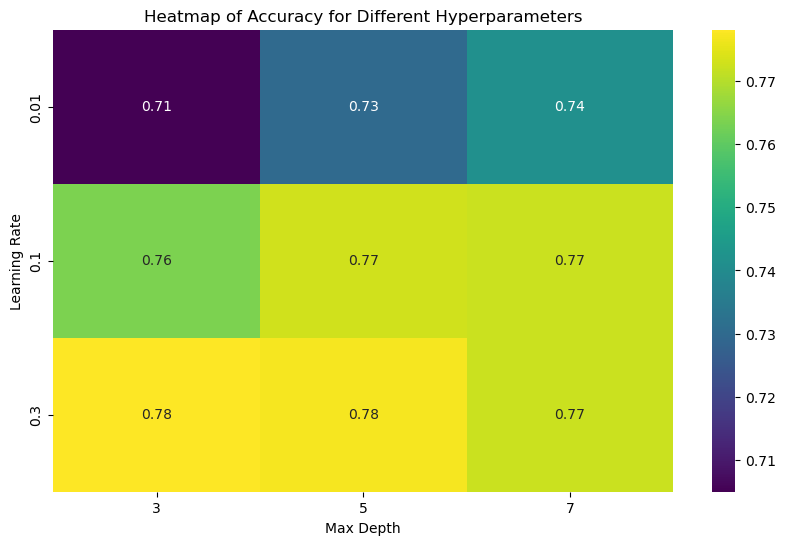

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert results_df to a pivot table for heatmap
heatmap_data = results_df.pivot_table(index='learning_rate', 
                                      columns='max_depth', 
                                      values='accuracy')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Accuracy for Different Hyperparameters')
plt.xlabel('Max Depth')
plt.ylabel('Learning Rate')
plt.show()


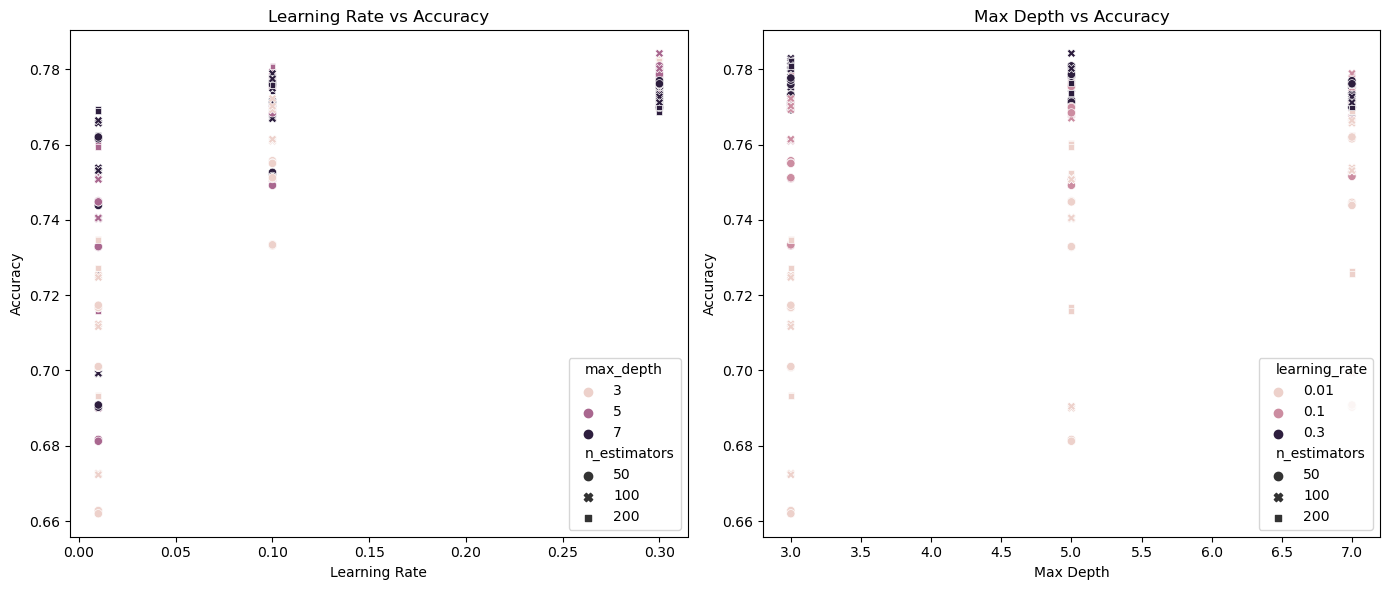

In [57]:
# Scatter plot for learning_rate vs accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=results_df, x='learning_rate', y='accuracy', hue='max_depth', style='n_estimators')
plt.title('Learning Rate vs Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

# Scatter plot for max_depth vs accuracy
plt.subplot(1, 2, 2)
sns.scatterplot(data=results_df, x='max_depth', y='accuracy', hue='learning_rate', style='n_estimators')
plt.title('Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


#### Result:
Best Model Performance:
Accuracy: 0.7843   
Classification Report:
              precision    recall  f1-score   support

          P1       0.84      0.77      0.80      1014
          P2       0.82      0.92      0.87      5045
          P3       0.48      0.30      0.37      1325
          P4       0.75      0.75      0.75      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.68      0.70      8413
weighted avg       0.76      0.78      0.77      8413

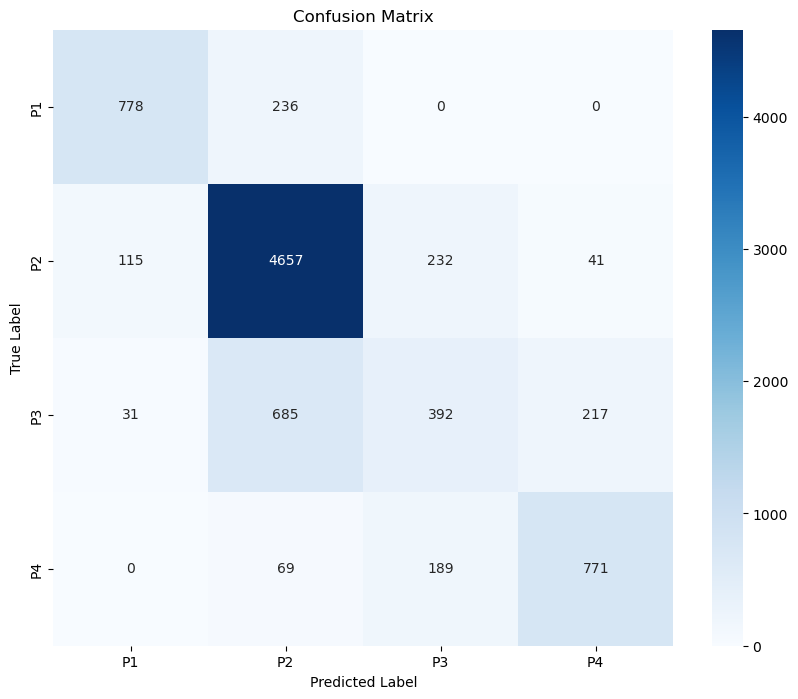

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true and predicted labels
# For the best model from previous code
# y_test: true labels
# y_pred_best: predicted labels from the best model

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Convert to DataFrame for better visualization with seaborn
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=label_encoder.classes_, 
                              columns=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
